# HW 3. Сканнер судоку

В этом задании, вам предлагается решить задачу распознавания чисел на решетке судоку. Для этого вам нужно реализовать следующие функции:

1. Конвертация в нужное цветовое пространство
2. Поиск решетки на изображении через контуры
3. Перспектива решетки судоку для распознавания
4. Выделение ячеек с числами
5. Обучение нейронной сети на MNIST
6. Распознавание цифр в судоку с помощью сети

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def READ_RGB(path):
    image=cv2.imread(path)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def SHOW_IMAGE(image):
    plt.imshow(image,cmap='gray')
    plt.show()

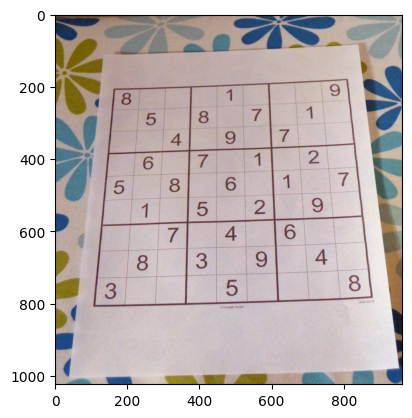

In [3]:
# Загружаем изображение
img_rgb = READ_RGB("sudoku.jpg")
SHOW_IMAGE(img_rgb)

## Бинаризация

TypeError: Image data of dtype object cannot be converted to float

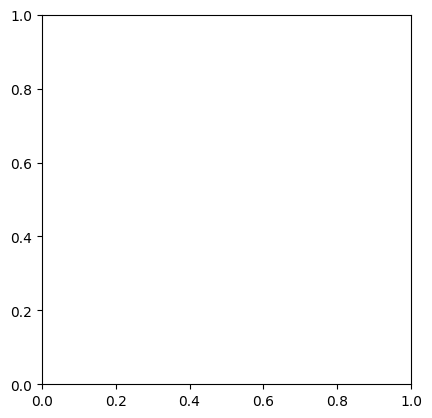

In [ ]:
# Перевод из RBG в Grayscale и накладываем фильтр
# Write your code here
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# Бинаризация
# Write your code here
img_bin = ...
SHOW_IMAGE(img_bin)

## Поиск контуров

На этом этапе мы хотим найти решетку с судоку. По нашему предположению, это наибольший по площади четырехугольник

In [ ]:
# Функция для уменьшения ребер в контуре, как на предыдущей лабе
def Approximating(contour,epsilon=.1):
    # Периметр контура
    length=cv2.arcLength(contour,True)
    # Аппроксимирует контурную форму к форме с меньшим количеством вершин
    # в зависимости от указанной точности. Это реализация алгоритма Рамера — Дугласа — Пекера.
    approx=cv2.approxPolyDP(contour,epsilon*length,True)
    return approx

In [ ]:
# Найдите контуры с помощью opencv
# Write your code here
contours = ...

In [ ]:
img_contours = img_rgb.copy()
# Write your code here
# Отсортируйте контуры по площади
contours_sorted = ...
# Аппроксимируйте контуры, чтобы с бОльшей вероятностью получить четырехугольник
approx_contours = [...]
# Выберите только те контуры, которые являются четырехугольникам
approx_rect = [...]
approx_rect = sorted(approx_rect, key=cv2.contourArea, reverse=True)

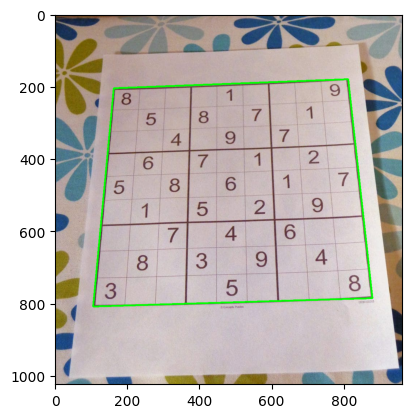

In [ ]:
cv2.drawContours(img_contours, approx_rect, 0, (0, 255, 0), 3)
SHOW_IMAGE(img_contours)

## WarpTransform

На этом этапе, мы сделаем перспективу решетки на новое изображение. Размерность нового изображения мы можем задать сами, поэтому упростим себе жизнь: пусть размер каждой ячейки будет 28x28, чтобы без лишних трансформаций отправлять их в нейронную сеть. Количество ячеек в судоку - 9 на 9. Таким образом, длина и ширина изображения будут 9x28 (мы не учитываем толщину линий между ячейчками)

In [ ]:
img_contours = img_rgb.copy()

output_size = 28 * 9

# Write your code here
# Составьте матрицу для warpPerspective и выполните трансформацию
M = ...
warped = cv2.warpPerspective(img_contours, M, (output_size, output_size))

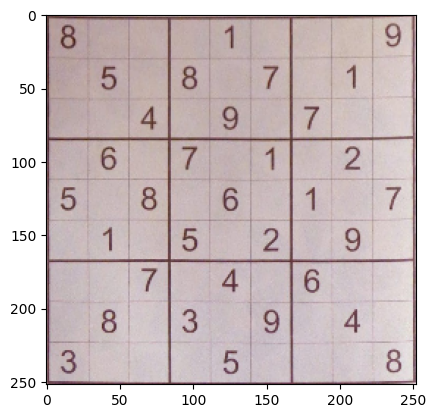

In [ ]:
SHOW_IMAGE(warped)

## Разделение

Дальше ячейки будем делить не по линиям на изображении, а по предварительным расчетам, что каждая цифра находится в ячейке размером 28 на 28, а размерность решетки судоку 9 на 9

В ячейки может попасть мусор в виде границ между ячейками. От него можно избавиться с помощью великолепной функции `clear_border`, которая удаляет все ненужные части изображения по краям.

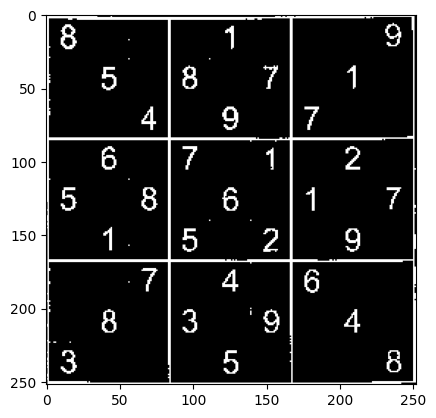

In [ ]:
gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
_, warped_binary = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
SHOW_IMAGE(warped_binary)

In [ ]:
from skimage.segmentation import clear_border

nCols = 9
nRows = 9
size = 28

grid = []
for i in range(0, nRows):
    grid.append([])
    for j in range(0, nCols):
      # Write your code here
      # Добавьте в grid соответствующий кусок изображения
      subImg = ...
      grid[i].append(clear_border(subImg))

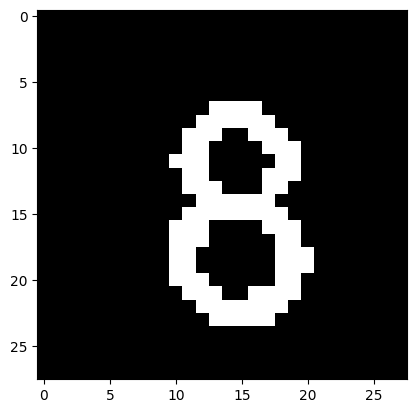

In [ ]:
SHOW_IMAGE(grid[0][0])

## Обучение сети для распознавания

Обучим простую сеть для распознавания цифр на MNIST. Поскольку вы уже делали похожие задания, здесь ничего дописывать не обязательно, код вернет приличную нейронку `model`, хотя вы можете попробовать по-экспериментировать с ней

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model, loss function and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100.*accuracy:.0f}%)\n')

# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:05<00:00, 1909243.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 150140.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1201558.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2936271.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294706
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.351857
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.115704
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.214519
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.191052
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.132948
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.092863
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.100629
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.254491
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.092584

Test set: Average loss: 0.4465, Accuracy: 9584/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.212925
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.143487
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.027172
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.145760
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.065836
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.021892
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.051843
Train Epoch: 2 [44800/6000

## Итоговое распознавание

Теперь мы можем проверить, как работает нейронка на кусках изображения из нашего судоку. Поскольку у модели нет класса "пустое изображение", которые встречается в нашем случае, придется отфильтровывать такие ячейки. Мы сделаем это из предположение, что если в ячейке нет контуров, то она пустая.

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpecte

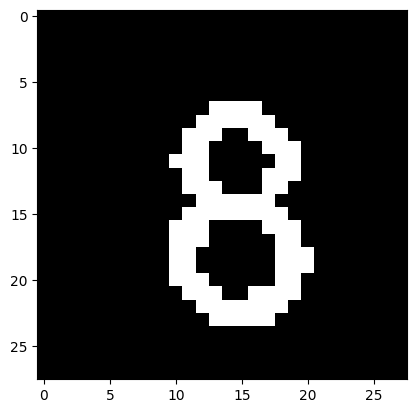

Some number in cell 0 0. Predicted: 8
Empty cell 0 1
Empty cell 0 2
Empty cell 0 3


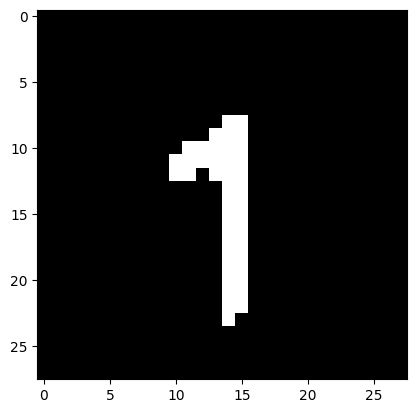

Some number in cell 0 4. Predicted: 1
Empty cell 0 5
Empty cell 0 6
Empty cell 0 7


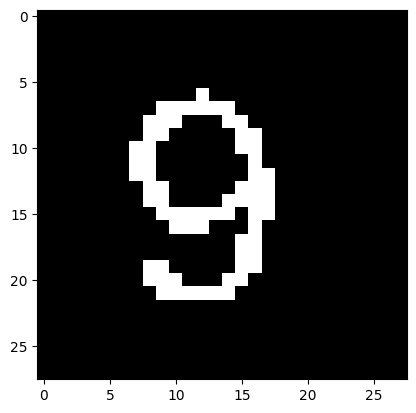

Some number in cell 0 8. Predicted: 9
Empty cell 1 0


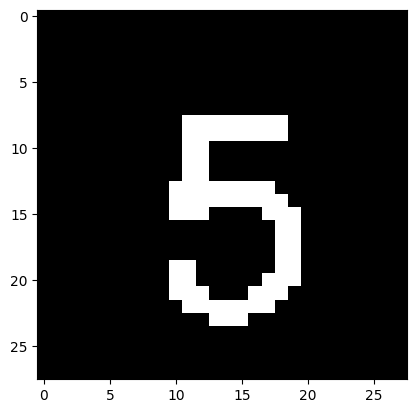

Some number in cell 1 1. Predicted: 5
Empty cell 1 2


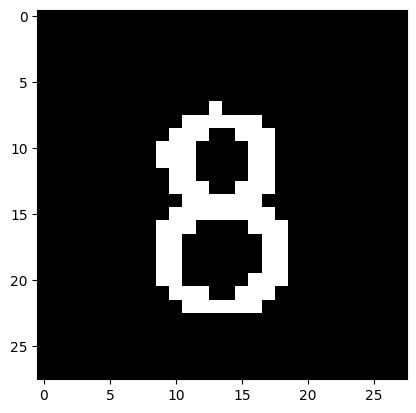

Some number in cell 1 3. Predicted: 8
Empty cell 1 4


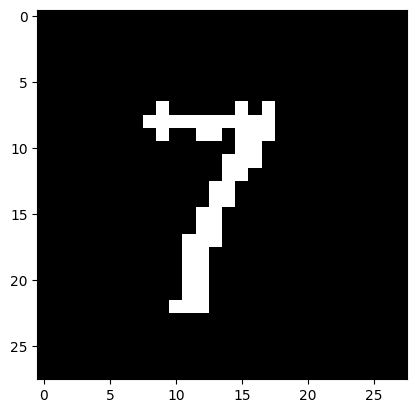

Some number in cell 1 5. Predicted: 7
Empty cell 1 6


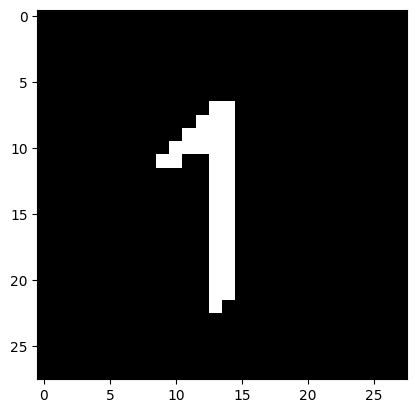

Some number in cell 1 7. Predicted: 1
Empty cell 1 8
Empty cell 2 0
Empty cell 2 1


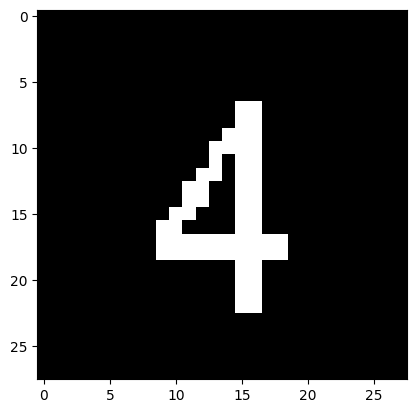

Some number in cell 2 2. Predicted: 4
Empty cell 2 3


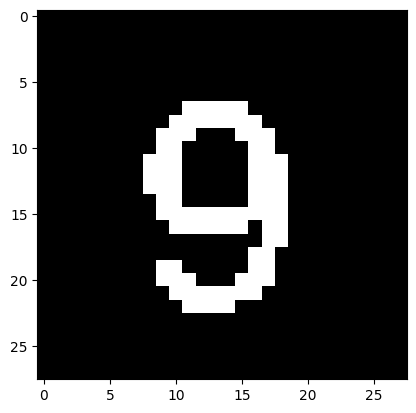

Some number in cell 2 4. Predicted: 9
Empty cell 2 5


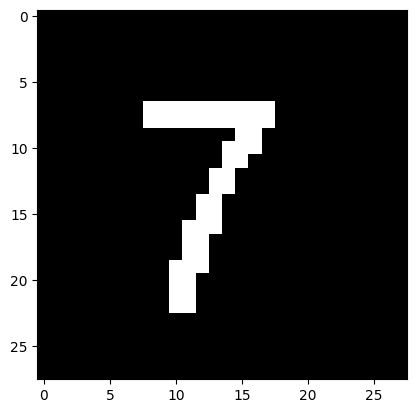

Some number in cell 2 6. Predicted: 7
Empty cell 2 7
Empty cell 2 8
Empty cell 3 0


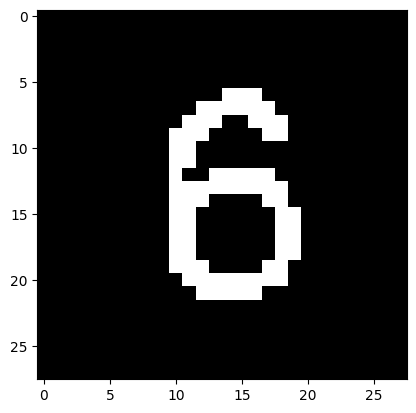

Some number in cell 3 1. Predicted: 5
Empty cell 3 2


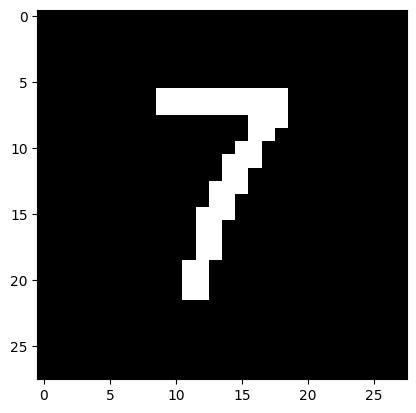

Some number in cell 3 3. Predicted: 7
Empty cell 3 4


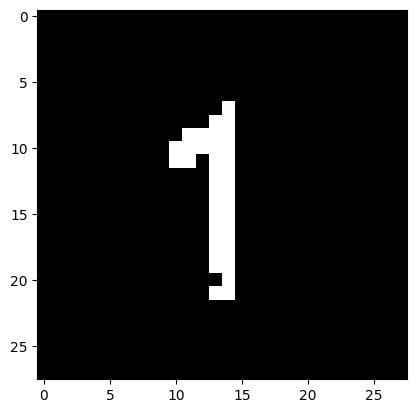

Some number in cell 3 5. Predicted: 1
Empty cell 3 6


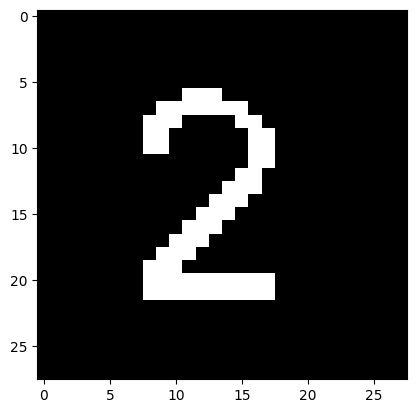

Some number in cell 3 7. Predicted: 2
Empty cell 3 8


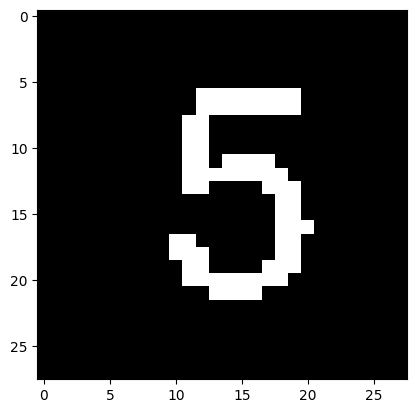

Some number in cell 4 0. Predicted: 5
Empty cell 4 1


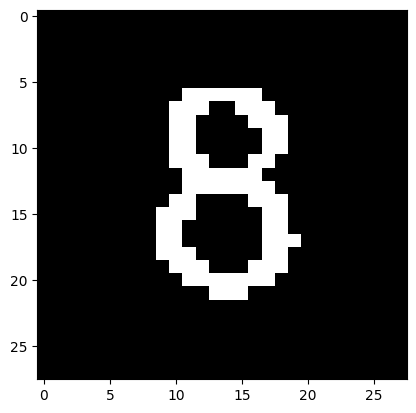

Some number in cell 4 2. Predicted: 9
Empty cell 4 3


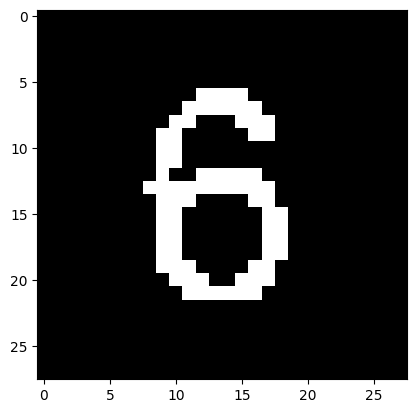

Some number in cell 4 4. Predicted: 0
Empty cell 4 5


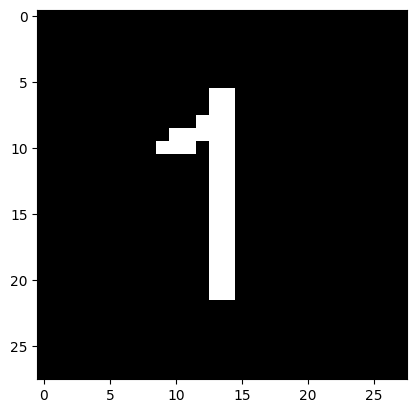

Some number in cell 4 6. Predicted: 1
Empty cell 4 7


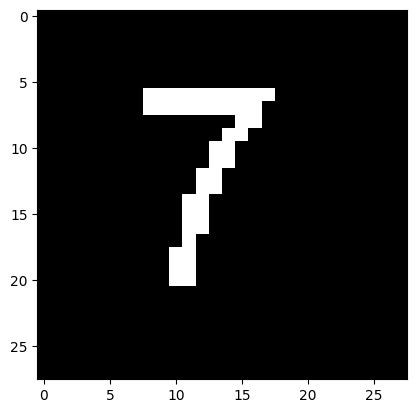

Some number in cell 4 8. Predicted: 7
Empty cell 5 0


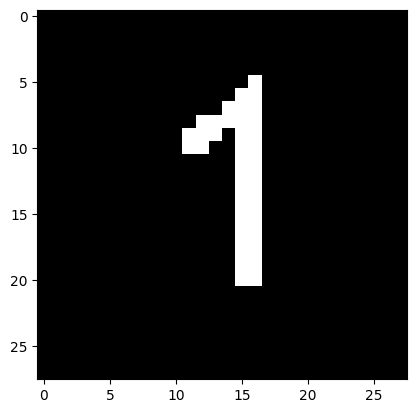

Some number in cell 5 1. Predicted: 7
Empty cell 5 2


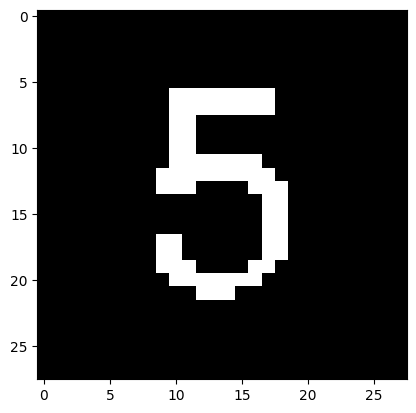

Some number in cell 5 3. Predicted: 5
Empty cell 5 4


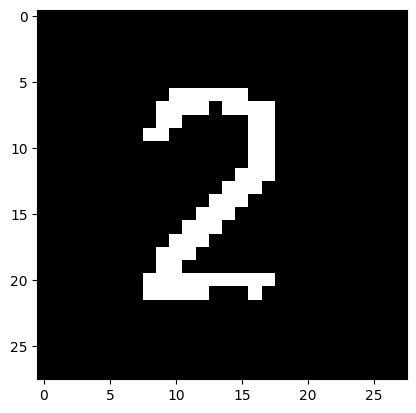

Some number in cell 5 5. Predicted: 2
Empty cell 5 6


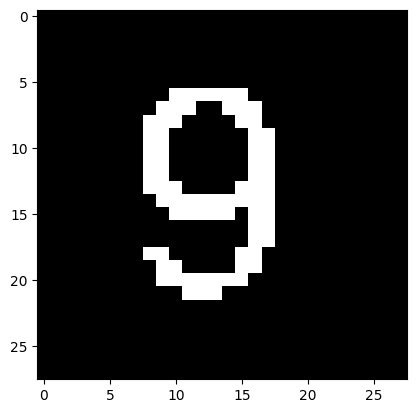

Some number in cell 5 7. Predicted: 9
Empty cell 5 8
Empty cell 6 0
Empty cell 6 1


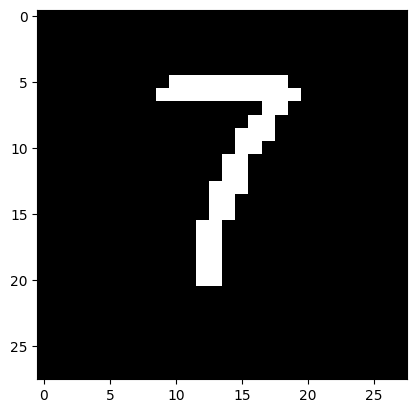

Some number in cell 6 2. Predicted: 7
Empty cell 6 3


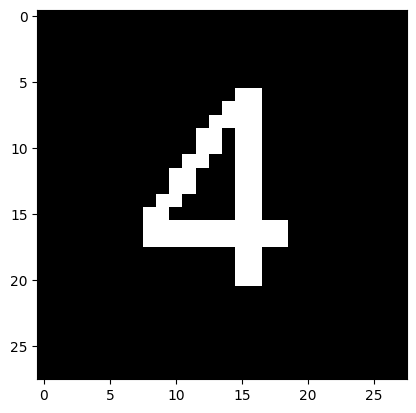

Some number in cell 6 4. Predicted: 4
Empty cell 6 5


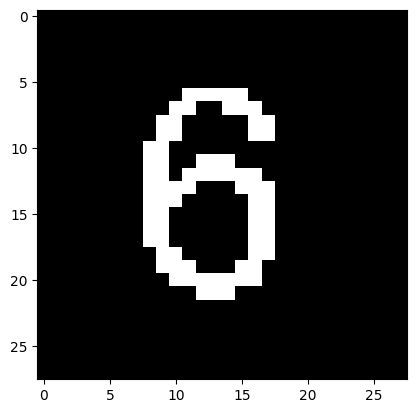

Some number in cell 6 6. Predicted: 0
Empty cell 6 7
Empty cell 6 8
Empty cell 7 0


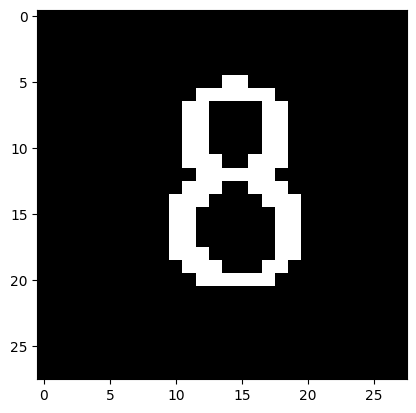

Some number in cell 7 1. Predicted: 0
Empty cell 7 2


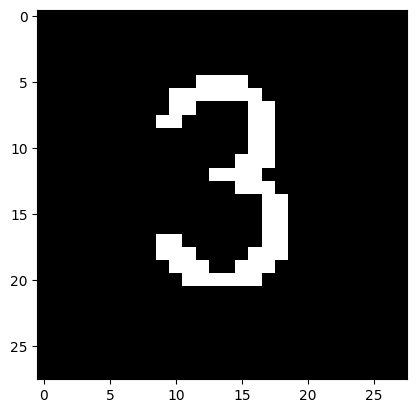

Some number in cell 7 3. Predicted: 3
Empty cell 7 4


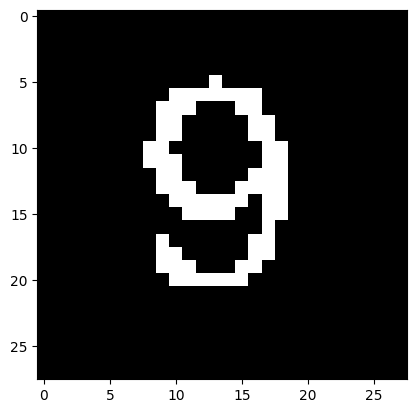

Some number in cell 7 5. Predicted: 9
Empty cell 7 6


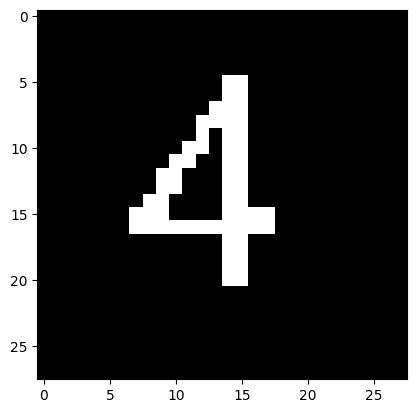

Some number in cell 7 7. Predicted: 4
Empty cell 7 8


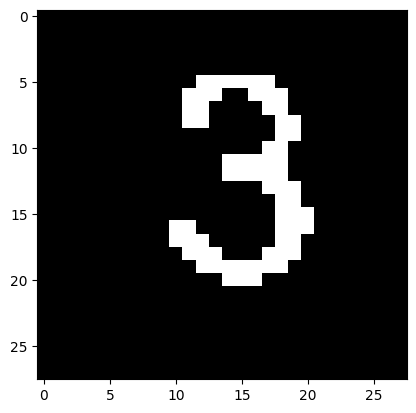

Some number in cell 8 0. Predicted: 3
Empty cell 8 1
Empty cell 8 2
Empty cell 8 3


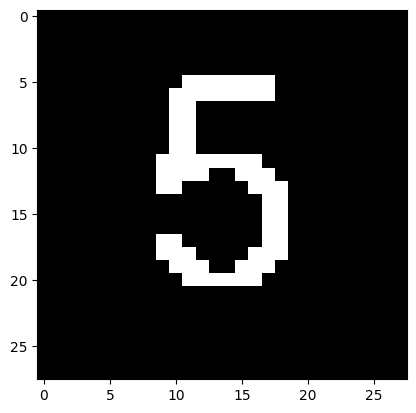

Some number in cell 8 4. Predicted: 5
Empty cell 8 5
Empty cell 8 6
Empty cell 8 7


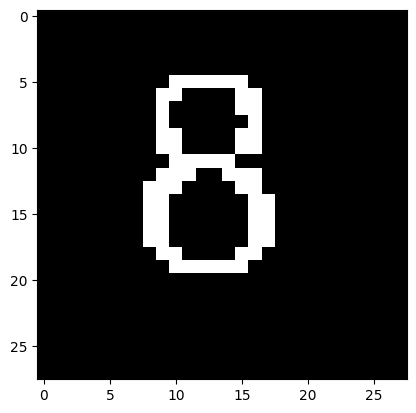

Some number in cell 8 8. Predicted: 4


In [ ]:
for i in range(0, nRows):
    for j in range(0, nCols):
        bb = grid[i][j]
        # Write your code here
        # Если в bb нет конкуров, выведите об этом сообщение. Иначе, отправьте bb в нейронку
        # и выведите предсказание. Не забудьте, что bb имеет размерность (28,28),
        # а нейронка работает с тензорами размерности (batch_size,1,28,28).